## We now have clean, good ride requests data.
### Cluster of Latitude-Longitude is done, we have around 50 pickup_clusters.
### We have grouped ride request day in 30mins interval. 

### Total Data Rows: 366days * 48 intervals * 50 clusters = 878400

### `AIM: To forecast demand for a given latitude-longitude`

### `Metric: RMSE, how close we are able to predict ride demand to true value`


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from math import sqrt, ceil, floor
import matplotlib.pyplot as plt
from xgboost import plot_importance
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from joblib import dump, load
%matplotlib inline

In [2]:
df = pd.read_csv('../Data/Data_Prepared.csv', compression = 'gzip')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878400 entries, 0 to 878399
Data columns (total 9 columns):
ts                878400 non-null object
pickup_cluster    878400 non-null int64
request_count     878400 non-null float64
mins              878400 non-null int64
hour              878400 non-null int64
day               878400 non-null int64
month             878400 non-null int64
dayofweek         878400 non-null int64
quarter           878400 non-null int64
dtypes: float64(1), int64(7), object(1)
memory usage: 60.3+ MB


In [4]:
df['request_count'] = pd.to_numeric(df['request_count'], downcast = 'integer')
df.ts = pd.to_datetime(df.ts)
df.head(10)

,ts,pickup_cluster,request_count,mins,hour,day,month,dayofweek,quarter
0,2020-03-26 00:00:00,0,0,0,0,26,3,3,1
1,2020-03-26 00:30:00,0,0,30,0,26,3,3,1
2,2020-03-26 01:00:00,0,0,0,1,26,3,3,1
3,2020-03-26 01:30:00,0,0,30,1,26,3,3,1
4,2020-03-26 02:00:00,0,0,0,2,26,3,3,1
5,2020-03-26 02:30:00,0,0,30,2,26,3,3,1
6,2020-03-26 03:00:00,0,0,0,3,26,3,3,1
7,2020-03-26 03:30:00,0,0,30,3,26,3,3,1
8,2020-03-26 04:00:00,0,0,0,4,26,3,3,1
9,2020-03-26 04:30:00,0,0,30,4,26,3,3,1


In [5]:
df = df[['ts','pickup_cluster','mins','hour','month','quarter','dayofweek','request_count']]

In [6]:
df

,ts,pickup_cluster,mins,hour,month,quarter,dayofweek,request_count
0,2020-03-26 00:00:00,0,0,0,3,1,3,0
1,2020-03-26 00:30:00,0,30,0,3,1,3,0
2,2020-03-26 01:00:00,0,0,1,3,1,3,0
3,2020-03-26 01:30:00,0,30,1,3,1,3,0
4,2020-03-26 02:00:00,0,0,2,3,1,3,0
...,...,...,...,...,...,...,...,...
878395,2021-03-26 21:30:00,49,30,21,3,1,4,11
878396,2021-03-26 22:00:00,49,0,22,3,1,4,13
878397,2021-03-26 22:30:00,49,30,22,3,1,4,13
878398,2021-03-26 23:00:00,49,0,23,3,1,4,10


In [7]:
# First 24days of every month in Train and last 7 days of everymonth in Test
df_train = df[df.ts.dt.day <=23]
df_test = df[df.ts.dt.day >23]

In [8]:
len(df_train)

662400

In [9]:
len(df_test)

216000

In [10]:
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
X_test = df_test.iloc[:,1:-1]
y_test = df_test.iloc[:,-1]

In [11]:
def metrics_calculate(regressor):
    y_pred = regressor.predict(X_test)
    rms = sqrt(mean_squared_error(y_test, y_pred))
    return rms

# Iteration: 1
Features: ['pickup_cluster','mins','hour','month','quarter','dayofweek']

In [12]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression().fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 7.399091635685108, RMSE TEST:7.272705604610569


### High Bais | Underfit
#### It is used to determine the extent to which there is a linear relationship between a dependent variable and one or more independent variables.
#### Moving to Ensemble Regressors: Bagging Algorithm Random Forest 
#### Random Forest Regressor: Random forests are bagged decision tree models that split on a subset of features on each split.
#### Give Feature importance based on target variable

In [13]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 300, random_state=42, n_jobs = -1, verbose=True)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.9min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    9.1s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:   42.7s
[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:  1.0min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.2s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    9.8s


RMSE TRAIN: 1.9343965753661254, RMSE TEST:4.439438294448992


[Parallel(n_jobs=12)]: Done 300 out of 300 | elapsed:   17.0s finished


In [14]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
pickup_cluster,0.461499
hour,0.252366
month,0.118886
quarter,0.077498
dayofweek,0.074334
mins,0.015416


### Random Forest Tend to Overfit

### Moving to a Ensemble: Boosting Algorithm
+ Here: learners are learned sequentially

In [13]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1000, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=15,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:8.30652
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:8.25391
[2]	validation_0-rmse:8.20041
[3]	validation_0-rmse:8.14891
[4]	validation_0-rmse:8.09713
[5]	validation_0-rmse:8.04817
[6]	validation_0-rmse:7.99791
[7]	validation_0-rmse:7.94862
[8]	validation_0-rmse:7.90017
[9]	validation_0-rmse:7.8528
[10]	validation_0-rmse:7.807
[11]	validation_0-rmse:7.7605
[12]	validation_0-rmse:7.71565
[13]	validation_0-rmse:7.67241
[14]	validation_0-rmse:7.62847
[15]	validation_0-rmse:7.58489
[16]	validation_0-rmse:7.54272
[17]	validation_0-rmse:7.50106
[18]	validation_0-rmse:7.45944
[19]	validation_0-rmse:7.4199
[20]	validation_0-rmse:7.38006
[21]	validation_0-rmse:7.34191
[22]	validation_0-rmse:7.3035
[23]	validation_0-rmse:7.26449
[24]	validation_0-rmse:7.22702
[25]	validation_0-rmse:7.19069
[26]	validation_0-rmse:7.15182
[27]	validation_0-rmse:7.11441
[28]	validation_0-rmse:7.0768
[29]	validation_0-rmse:7.04021
[30]	validation_0-rmse

In [14]:
dump(model,'../Model/prediction_model_without_lag.joblib',compress=3)

['../Model/prediction_model_without_lag.joblib']

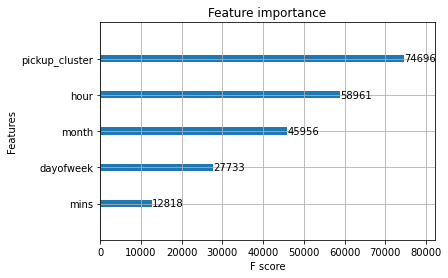

In [15]:
# plot feature importance
plot_importance(model)


# Iteration 2
Features: ['pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3']

## Include: Lag Features

### If there is 30mins trend, how has ride requests been in last 1.5 hours. 
+ Hence testing with Lag Shift by 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.

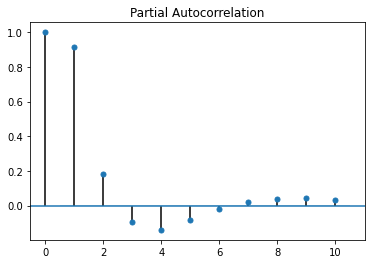

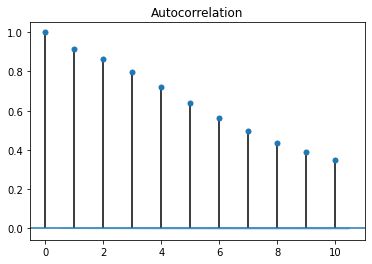

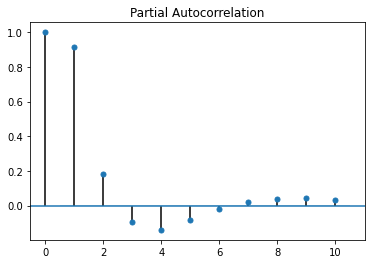

In [17]:
plot_acf(df_train['request_count'], lags=10)
plot_pacf(df_train['request_count'], lags=10)

The partial autocorrelation function shows a high correlation with the first two lag and lesser correlation with the 3rd and 4th lag. The autocorrelation function shows a slow decay, which means that the future values have a very high correlation with its past values.

+ ACF: The ACF plot is a measure of the correlation between the time series and the lagged version of itself
+ PACF: The PACF plot is a measure of the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons

In [18]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp.head(15)

,,,,,,,request_count,lag_1,lag_2,lag_3
ts,pickup_cluster,mins,hour,month,quarter,dayofweek,,,,
2020-03-26 00:00:00,0,0,0,3,1,3,0,NaN,NaN,NaN
2020-03-26 00:30:00,0,30,0,3,1,3,0,0.0,NaN,NaN
2020-03-26 01:00:00,0,0,1,3,1,3,0,0.0,0.0,NaN
2020-03-26 01:30:00,0,30,1,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:00:00,0,0,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 02:30:00,0,30,2,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:00:00,0,0,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 03:30:00,0,30,3,3,1,3,0,0.0,0.0,0.0
2020-03-26 04:00:00,0,0,4,3,1,3,0,0.0,0.0,0.0


In [19]:
temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins','hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3',
        'request_count']]

In [20]:
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

In [21]:
X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [22]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
regressor.fit(X,y)
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

RMSE TRAIN: 0.9780860635897497, RMSE TEST:2.58343218496114


### Random Fores - Overfits || Moving to Boosting Algorithm

In [23]:
feature_importances = pd.DataFrame(regressor.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
lag_1,0.837019
hour,0.038416
lag_2,0.032031
pickup_cluster,0.028569
lag_3,0.023946
dayofweek,0.015573
month,0.014705
mins,0.006398
quarter,0.003342


In [25]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=600, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=30,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:8.29025
Will train until validation_0-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:8.21808
[2]	validation_0-rmse:8.14638
[3]	validation_0-rmse:8.07542
[4]	validation_0-rmse:8.00547
[5]	validation_0-rmse:7.93616
[6]	validation_0-rmse:7.86751
[7]	validation_0-rmse:7.79907
[8]	validation_0-rmse:7.73179
[9]	validation_0-rmse:7.66572
[10]	validation_0-rmse:7.60054
[11]	validation_0-rmse:7.5358
[12]	validation_0-rmse:7.4718
[13]	validation_0-rmse:7.40848
[14]	validation_0-rmse:7.34548
[15]	validation_0-rmse:7.28366
[16]	validation_0-rmse:7.22198
[17]	validation_0-rmse:7.16184
[18]	validation_0-rmse:7.10215
[19]	validation_0-rmse:7.04276
[20]	validation_0-rmse:6.98429
[21]	validation_0-rmse:6.92632
[22]	validation_0-rmse:6.86941
[23]	validation_0-rmse:6.81268
[24]	validation_0-rmse:6.75661
[25]	validation_0-rmse:6.70131
[26]	validation_0-rmse:6.64662
[27]	validation_0-rmse:6.59236
[28]	validation_0-rmse:6.53882
[29]	validation_0-rmse:6.48587
[30]	validation_0

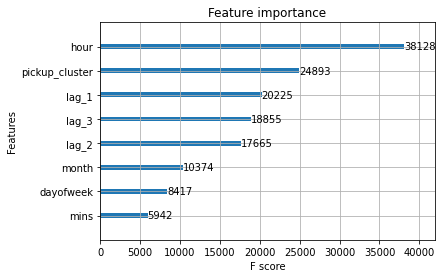

In [26]:
plot_importance(model)

### Xgboost perform better than random forest

<hr>

# Iteration3:
Features: ['pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean']
## Include: Both Lag Features and Rolling Window
+ Both of size = 3

lag_{t} = this is simply the request_count of a region {t} mins/hours ago.
<br>
rolling_mean: previous 3 days request_count mean

In [16]:
df_test = df_test.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = pd.concat([df_train,df_test])
temp = temp.sort_values(by=['pickup_cluster', 'ts']).drop_duplicates(subset=['ts','pickup_cluster'])
temp = temp.set_index(['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter', 'dayofweek'])

temp['lag_1'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(1)
temp['lag_2'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(2)
temp['lag_3'] = temp.groupby(level=['pickup_cluster'])['request_count'].shift(3)
temp['rolling_mean'] = temp.groupby(level=['pickup_cluster'])['request_count'].apply(lambda x: x.rolling(window = 3).mean()).shift(1)

temp = temp.reset_index(drop = False).dropna()
temp = temp[['ts', 'pickup_cluster', 'mins', 'hour', 'month', 'quarter',
       'dayofweek', 'lag_1', 'lag_2', 'lag_3','rolling_mean','request_count']]
train1 = temp[temp.ts.dt.day <=23]
test1 = temp[temp.ts.dt.day >23]

X = train1.iloc[:, 1:-1]
y = train1.iloc[:, -1]
X_test = test1.iloc[:, 1:-1]
y_test = test1.iloc[:, -1]

In [17]:
# from sklearn.ensemble import RandomForestRegressor
# regressor = RandomForestRegressor(n_estimators = 500, random_state=0, n_jobs = -1)
# regressor.fit(X,y)
# print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, regressor.predict(X))), metrics_calculate(regressor)))

# feature_importances = pd.DataFrame(regressor.feature_importances_,
#                                    index = X.columns,
#                                     columns=['importance']).sort_values('importance',ascending=False)
# feature_importances

In [18]:
# dump(regressor, 'random_forest.joblib')

## Random Forest Overfits i.e. performs good on training dataset and bad on test dataset

In [19]:
## XGBoost
import xgboost as xgb
model=xgb.XGBRegressor(learning_rate=0.01, random_state=0, n_estimators=1500, max_depth=8, objective="reg:squarederror")

eval_set = [(X_test, y_test)]
model.fit(X,y,verbose=True, eval_set=eval_set, early_stopping_rounds=20,eval_metric="rmse")
print("XGBOOST Regressor")
print("Model Score:",model.score(X,y))
print("RMSE TRAIN: {}, RMSE TEST:{}".format(sqrt(mean_squared_error(y, model.predict(X))), metrics_calculate(model)))

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:8.28999
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:8.21758
[2]	validation_0-rmse:8.14566
[3]	validation_0-rmse:8.07464
[4]	validation_0-rmse:8.00427
[5]	validation_0-rmse:7.93453
[6]	validation_0-rmse:7.86569
[7]	validation_0-rmse:7.7972
[8]	validation_0-rmse:7.73024
[9]	validation_0-rmse:7.66368
[10]	validation_0-rmse:7.59799
[11]	validation_0-rmse:7.53296
[12]	validation_0-rmse:7.46855
[13]	validation_0-rmse:7.405
[14]	validation_0-rmse:7.34186
[15]	validation_0-rmse:7.27974
[16]	validation_0-rmse:7.21814
[17]	validation_0-rmse:7.15751
[18]	validation_0-rmse:7.09775
[19]	validation_0-rmse:7.03806
[20]	validation_0-rmse:6.97938
[21]	validation_0-rmse:6.92144
[22]	validation_0-rmse:6.86403
[23]	validation_0-rmse:6.80739
[24]	validation_0-rmse:6.75107
[25]	validation_0-rmse:6.69561
[26]	validation_0-rmse:6.64078
[27]	validation_0-rmse:6.58602
[28]	validation_0-rmse:6.53247
[29]	validation_0-rmse:6.47962
[30]	validation_0-

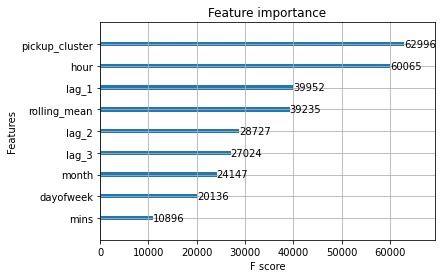

In [20]:
plot_importance(model)

In [21]:
dump(model,'../Model/prediction_model.joblib',compress=3)

['../Model/prediction_model.joblib']

### Comment: Lag Features and Rolling Mean has improved RMSE

<hr>

# Final Model: Iteration3
+ Good performance with feature addition

# Has Features: `['pickup_cluster','mins','hour','month','dayofweek','quarter', 'lag_1','lag_2','lag_3','rolling_mean']`

### Model Score: 0.91

In [33]:
model = load('../Model/prediction_model.joblib')

In [34]:
model.predict(X_test)

array([ 0.21119007,  0.22959417,  0.22166237, ..., 10.994667  ,
        9.126653  ,  7.051732  ], dtype=float32)